In [124]:
import pandas as pd
import xarray as xr
import requests
import matplotlib.pyplot as plt

## Section 1: Storm Reports ##

In [160]:
#Gets wind report on given date as a pandas dataframe
def get_wind_report(datetime):
    date = datetime.strftime("%y%m%d")
    df = request_wind_report_df(date)    
    df = add_datetime(df, datetime)
    return df

#Helper functions 
#Requests the wind report from the NOAA website and cleans up the data
def request_wind_report_df(date):
    #Actual request
    link = generate_link(date)
    data = requests.get(link)
    #Turns csv string into dataFrame
    csv_string = data.text
    data = [row.split(',') for row in csv_string.split('\n')]
    data.pop(-1)
    columns = data.pop(0)
    data.pop(0)
    #Returns dataframe 
    df = pd.DataFrame(data, columns=columns)
    df["Lat"] = df["Lat"].astype("float")
    df["Lon"] = df["Lon"].astype("float")
    return df

#Adds date time column to the dataframe
def add_datetime(df, datetime):
    time = df["Time"]
    #TODO: Rename foo function
    df["datetime"] = [foo(datetime, t) for t in time]
    df['datetime'] = pd.to_datetime(df["datetime"])
    #Removes Time column
    df.drop(columns=["Time"], inplace=True)
    return df 

#Corrects the date for a given report
#TODO: Rename this function
def foo(datetime, time):
    day = datetime.day if int(time[0] + time[1]) >= 12 else (datetime + pd.Timedelta(days = 1)).day
    dt = pd.Timestamp(year=datetime.year, month=datetime.month,
                                   day=day, hour=int(time[0] + time[1]),
                                  minute = int(time[2] + time[3]))
    return dt



#Generates link to csv download of wind report on given date. Date format "yymmdd"
def generate_link(date):
    return f'https://www.spc.noaa.gov/climo/reports/{date}_rpts_wind.csv'



In [161]:
#Returns pandas dataframe with wind reports for given date range
def get_weather_reports(start_date, end_date):    
    i = 0
    for date in generate_days(start_date, end_date):
        df = get_wind_report(date)
        if i == 0:
            big_df = df
            i += 1
        else :
            big_df = pd.concat([big_df, df])
    big_df.reset_index(inplace=True)
    return big_df

#Helper function
#Generates dates in format "yymmdd"
def generate_days(start_date, end_date):
    
    days = pd.period_range(start=start_date, end=end_date)
    # days = [day.strftime("%y%m%d") for day in days]
    return days


In [162]:
#Applies filters to the storm report dataset
def filter_reports(df, center_event, distance, hours):
    spatially_filtered = spatial_filter(df, center_event["Lat"], center_event["Lon"], distance)
    temporally_filtered = temporal_filter(spatially_filtered, hours,center_event["datetime"], )
    return temporally_filtered

#Filters the storm reports so that only the ones that are +- hours from the given date time
def temporal_filter(df, hours, date_time):
    filtered_df = df[df["datetime"] >= (date_time - pd.Timedelta(hours=hours))]
    time_filtered_events = filtered_df[filtered_df["datetime"] <= (date_time + pd.Timedelta(hours=hours))]
    return time_filtered_events

#Filters storm reports so that only the ones that are +- distance from given lat/lon
#TODO: Enhance so that we can give the distance in kilometers
def spatial_filter(df, lat, lon, distance):
    let_filtered_df = latitude_filter(df, lat, distance)
    filtered_df = longitude_filter(df, lon, distance)
    return filtered_df

#Helper functions for the spatial filter
def latitude_filter(df, lat, distance):
    lat_filtered = df[df["Lat"] <= lat + distance]
    lat_filtered = lat_filtered[lat_filtered["Lat"] >= lat - distance]
    return lat_filtered

def longitude_filter(df, lon, distance):
    lon_filtered = df[df["Lon"] <= lon + distance]
    lon_filtered = lon_filtered[lon_filtered["Lon"] >= lon - distance]
    return lon_filtered
    

In [163]:
#Wind reports for June 7 2023
get_wind_report(pd.Timestamp(year=2023, month=6, day=7))

,Speed,Location,County,State,Lat,Lon,Comments,datetime
0,UNK,3 NE Reese,Warren,GA,33.37,-82.55,Trees and powerlines down at Ricketson Road ne...,2023-06-07 19:37:00
1,UNK,2 NNE Reese,Warren,GA,33.37,-82.56,Trees and powerlines down on Little Briar Cree...,2023-06-07 19:37:00
2,UNK,2 WSW Franklinton,Bibb,GA,32.79,-83.57,Trained spotter reports that a microburst occu...,2023-06-07 19:38:00
3,UNK,3 NNE Cope,Orangeburg,SC,33.42,-80.98,Trees and power lines down at Shillings Bridge...,2023-06-07 20:12:00
4,UNK,4 SW Logan Center,Grand Forks,ND,47.77,-97.87,Corrects previous tstm wnd dmg report from 4 S...,2023-06-07 20:13:00
...,...,...,...,...,...,...,...,...
71,59,Laughlin AFB,Val Verde,TX,29.36,-100.78,(EWX),2023-06-08 06:23:00
72,UNK,2 NNE Bergen,Jackson,MN,43.82,-94.99,A large cottonwood tree was uprooted. Grain au...,2023-06-08 07:03:00
73,UNK,5 S Bergen,Jackson,MN,43.72,-95.00,Ten power poles snapped off for a half mile we...,2023-06-08 07:14:00
74,UNK,3 NE Harris,Osceola,IA,43.48,-95.39,Grain bin and large trees damaged by thunderst...,2023-06-08 08:57:00


Generates wind reports for dates in a given range 

In [129]:
#Generates wind reports until the most recent day
start_date = pd.Timestamp(year=2023, month=5, day=8)
end_date = pd.Timestamp(year=2023, month=6, day=14)
reports = get_weather_reports(start_date, end_date)
reports 

,index,Speed,Location,County,State,Lat,Lon,Comments,datetime
0,0,UNK,4 NNW BEVIL OAKS,HARDIN,TX,30.22,-94.29,HARDIN 911 REPORTS POSSIBLE TORNADO TOUCHED DO...,2023-05-08 20:10:00
1,1,UNK,3 WNW LUMBERTON,HARDIN,TX,30.27,-94.25,NUMEROUS POWER OUTAGES REPORTED IN AND AROUND ...,2023-05-08 20:25:00
2,2,UNK,3 NW LEWISTON,NEZ PERCE,ID,46.42,-117.03,DELAYED REPORT FROM MAY 8TH. GUSTY WINDS FROM ...,2023-05-08 20:30:00
3,3,UNK,4 NW BEAUMONT,JEFFERSON,TX,30.14,-94.18,SOFTWOOD TREE SPLIT IN HALF. (LCH),2023-05-08 20:42:00
4,4,59,3 NNW BRIDGE CITY,ORANGE,TX,30.08,-93.87,MESONET REPORTS THUNDERSTORM WIND GUST OF 59 M...,2023-05-08 21:19:00
...,...,...,...,...,...,...,...,...,...
2434,345,UNK,3 SW Belleview,Marion,FL,29.03,-82.09,Marion County 911/Dispatch reports a tree down...,2023-06-15 04:25:00
2435,346,UNK,Sneads,Jackson,FL,30.68,-84.93,Jackson county continues to receive numerous r...,2023-06-15 04:30:00
2436,347,UNK,Greensboro,Gadsden,FL,30.57,-84.57,Several trees down in Gadsden county. (TAE),2023-06-15 04:45:00
2437,348,76,3 SW Oxford,La Plata,CO,37.14,-107.76,(GJT),2023-06-15 05:07:00


Deals with the filtering of storm report data. Can filter spatially and temporally. 

In [37]:
report = reports[reports['Lat'] == 32.32]
report = report.loc[1439]

In [38]:
spatial_filter(reports, report["Lat"],report["Lon"], 1)

,index,Speed,Location,County,State,Lat,Lon,Comments,datetime
152,82,80,6 W REDINGTON,BANNER,NE,41.61,-103.41,TRAINED SPOTTER REPORTED VERY STRONG WIND GUST...,2023-05-09 23:05:00
155,85,60,5 WSW REDINGTON,BANNER,NE,41.56,-103.38,TRAINED STORM SPOTTER REPORTED 60 MPH GUSTS. T...,2023-05-09 23:15:00
165,95,61,PERSIMMON GAP,BREWSTER,TX,29.66,-103.18,MESONET STATION 72 BIG BEND NP/BREWSTER COUNTY...,2023-05-09 23:54:00
194,124,64,7 WNW LORENZO,CHEYENNE,NE,41.07,-103.16,MESONET STATION FW8225 SIDNEY. (CYS),2023-05-10 09:30:00
214,19,71,1 E CLAYTON,UNION,NM,36.45,-103.15,ASOS STATION KCAO CLAYTON MUNI AIRPARK. FIRST ...,2023-05-10 22:38:00
...,...,...,...,...,...,...,...,...,...
1832,144,66,1 E Happy,Swisher,TX,34.74,-101.84,West Texas Mesonet at Happy 1E. (LUB),2023-06-12 01:29:00
1838,150,58,3 SSE Boise City,Cimarron,OK,36.69,-102.50,(AMA),2023-06-12 01:50:00
1896,208,60,4 WNW Stratford,Sherman,TX,36.36,-102.13,(AMA),2023-06-12 04:27:00
1905,217,71,3 SW Dalhart,Hartley,TX,36.02,-102.55,(AMA),2023-06-12 08:10:00


## Section 2: RRFS Model Data ##

In [130]:
from rrfs import rrfs
r = rrfs.Rrfs()

#Inputs storm_report row and the forecast hour
#Outputs xarray dataset with model forecast
def fetch_rrfs_forecast(storm_report, forecast_hour):
    initialization_date = get_initialization_date(storm_report, forecast_hour)
    return r.fetch_model_output(initialization_date, forecast_hour)

#Helper function
#Gets initialization hour for given storm report and its forecast hour
def get_initialization_date(storm_report, forecast_hour):
    print(storm_report["datetime"], forecast_hour)
    initialization_date = storm_report["datetime"] - pd.Timedelta(hours=forecast_hour)
    return initialization_date
   

In [131]:
#Given a xarray dataset, interesting_event and distance, filters the dataset to only contain cells += distance from the center event
def bounding_indexes(ds, i_event, distance):
    lat_grid, lon_grid = ds['gridlat_0'].values, ds['gridlon_0'].values
    lat, lon = i_event["Lat"], i_event["Lon"]
    lat_size = len(lat_grid) #1059
    lon_size = len(lat_grid[0]) #1799
        
    lat_indexes, lon_indexes = [], []
    
    for lat_index in range(lat_size):
        for lon_index in range(lon_size):
            if abs(lat_grid[lat_index][lon_index] - lat) < distance and abs(lon_grid[lat_index][lon_index] - lon) < distance:
                lat_indexes.append(lat_index)
                lon_indexes.append(lon_index)

    min_lat_index, max_lat_index = min(lat_indexes), max(lat_indexes)
    min_lon_index, max_lon_index = min(lon_indexes), max(lon_indexes)
    return min_lat_index, max_lat_index, min_lon_index, max_lon_index

#Helper function i think
def get_coords(ds, lat_ind, lon_ind):
    return ds.coords["gridlat_0"][lat_ind, lon_ind].values, ds.coords["gridlon_0"][lat_ind, lon_ind].values

#Unused
def get_latlons(min_lat, max_lat, min_lon, max_lon):
    lats = []
    lons = []
    for lat_index in range(min_lat, max_lat):
        for lon_index in range(min_lon, max_lon):
            lat, lon = get_coords(ds, lat_index, lon_index)
            lats.append(lat)
            lons.append(lon)
    return lats, lons

In [120]:
#TODO: Add something that returns xarray dataset with only the given variable or variables

## Section 3: Plotting Data ##

In [136]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#Plots weather reports
def plot_storm_reports(events, center_event, distance):

    figure = plt.figure()
    
    ax = figure.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES)
    ax.set_extent(
        [center_event["Lon"] - distance, center_event["Lon"] + distance, center_event["Lat"] - distance, center_event["Lat"] + distance],
        crs=ccrs.PlateCarree()
    )
    plt.scatter(
        x = events["Lon"],
        y = events["Lat"],
        color="red",
        s=2,
        alpha=1,
        transform=ccrs.PlateCarree()
    )

    plt.scatter(
        x = center_event["Lon"],
        y = center_event["Lat"],
        color="green",
        s=4,
        alpha=1,
        transform=ccrs.PlateCarree()
    )

    
    plt.show()

In [133]:
# Wind Speed Calculation

import matplotlib.pyplot as plt
import metpy.calc as mpcalc

#Plots winds speed and 
def plot_wind_speed(ds, interesting_events, center_event, offset=3):

    # Calculate the total deformation of the flow
    wind_speed = mpcalc.wind_speed(ds.UGRD_P0_L103_GLC0, ds.VGRD_P0_L103_GLC0)
    # start figure and set axis
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # plot wind speed
    cf = ax.contourf(ds.coords['gridlon_0'], 
                     ds.coords['gridlat_0'], 
                     wind_speed, cmap=plt.cm.BuPu)
    plt.colorbar(cf, pad=0, aspect=50)
    ax.barbs(ds.coords['gridlon_0'][0::offset, 0::offset],
             ds.coords['gridlat_0'][0::offset, 0::offset],
             ds.UGRD_P0_L103_GLC0[0::offset, 0::offset], 
             ds.VGRD_P0_L103_GLC0[0::offset, 0::offset], 
             color='black', length=5, alpha=0.5)
   
    ax.set_title('Wind Speed Calculation')
    
    plt.scatter(
            x = interesting_events["Lon"],
            y = interesting_events["Lat"],
            color="red",
            s=2,
            alpha=1
        )
    
    plt.scatter(
        x=center_event["Lon"],
        y=center_event["Lat"],
        color="Orange",
        s=5
    )
    plt.show()

#Plots the max wind speed variable
def plot_max_wind_speed(ds, interesting_events, center_event, offset=3):

    # Calculate the total deformation of the flow
    wind_speed = mpcalc.wind_speed(ds.MAXUW_P8_L103_GLC0_max1h, ds.MAXVW_P8_L103_GLC0_max1h)
    # start figure and set axis
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # plot wind speed
    cf = ax.contourf(ds.coords['gridlon_0'], 
                     ds.coords['gridlat_0'], 
                     wind_speed, cmap=plt.cm.YlGn)
    plt.colorbar(cf, pad=0, aspect=50)
    ax.barbs(ds.coords['gridlon_0'][0::offset, 0::offset],
             ds.coords['gridlat_0'][0::offset, 0::offset],
             ds.UGRD_P0_L103_GLC0[0::offset, 0::offset], 
             ds.VGRD_P0_L103_GLC0[0::offset, 0::offset], 
             color='black', length=5, alpha=0.5)
   
    ax.set_title('Max Wind Speed')
    
    plt.scatter(
            x = interesting_events["Lon"],
            y = interesting_events["Lat"],
            color="red",
            s=2,
            alpha=1
        )
    
    plt.scatter(
        x=center_event["Lon"],
        y=center_event["Lat"],
        color="Orange",
        s=5
    )
    plt.show()




In [178]:
#Top level function that puts everything together
def plot_interesting_events(center_event, storm_reports, forecast_hour, distance, time):
    offset = 10
    #Fetches forecast
    ds = fetch_rrfs_forecast(center_event, forecast_hour)
    interesting_events = filter_reports(storm_forecasts, center_event, distance, time)
    #Filters the dataset
    mla, Mla, mlo, Mlo = bounding_indexes(ds, center_event, distance)
    new_ds = ds.isel(ygrid_0=range(mla,Mla), xgrid_0=range(mlo,Mlo))
    #TODO: Call the function that returns the given variable
    #TODO: Be smarter in how the plotting is done
    plot_wind_speed(new_ds, interesting_events, center_event, offset)
    plot_max_wind_speed(new_ds, interesting_events, center_event, offset)


In [173]:
def aaa(wind_reports):
    distance = 1
    hours = 1.5
    cool_events = []
    for index, row in wind_reports.iterrows():
        # print(row)
        a = filter_reports(wind_reports, row, distance, hours)
        if len(a) > 20:
            cool_events.append(row)
    return cool_events

In [174]:
cool_events = aaa(wind_reports)

In [177]:
plot_interesting_events(cool_events[0], wind_reports, 3, 1)

[Speed                       UNK
 Location          2 S Lexington
 County                   Holmes
 State                        MS
 Lat                       33.09
 Lon                      -90.06
 Comments    Trees downed. (JAN)
 datetime    2023-06-14 19:58:00
 Name: 90, dtype: object,
 Speed                                                     UNK
 Location                                       2 SW Lexington
 County                                                 Holmes
 State                                                      MS
 Lat                                                     33.09
 Lon                                                    -90.07
 Comments    Tree downed on downed on powerline hitting a h...
 datetime                                  2023-06-14 19:58:00
 Name: 91, dtype: object,
 Speed                                      UNK
 Location                             Lexington
 County                                  Holmes
 State                              

# 1. June 14 2023 #

In [159]:
wind_reports = get_wind_report(pd.Timestamp(year=2023, month=6, day=14))
wind_reports

TypeError: foo() takes 1 positional argument but 2 were given

In [145]:
florida_report = wind_reports.loc[347]
florida_report

Speed                                               UNK
Location                                     Greensboro
County                                          Gadsden
State                                                FL
Lat                                               30.57
Lon                                              -84.57
Comments    Several trees down in Gadsden county. (TAE)
datetime                            2023-06-15 04:45:00
Name: 347, dtype: object

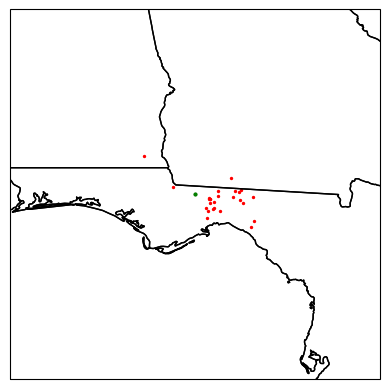

In [154]:
distance = 1
time = 4
florida_filtered_reports = filter_reports(wind_reports, florida_report, distance, time)
plot_storm_reports(florida_filtered_reports, florida_report, 3)

In [85]:
plot_interesting_eventsData(florida_report, fi)

,Speed,Location,County,State,Lat,Lon,Comments,datetime
32,UNK,3 SW Domino,Cass,TX,33.22,-94.15,Reports of damaged structures and several vehi...,2023-06-14 17:50:00


## 1.1 Texas Storm ##

In [55]:
tx_report = wind_reports.loc[32]
tx_report

Speed                                                     UNK
Location                                          3 SW Domino
County                                                   Cass
State                                                      TX
Lat                                                     33.22
Lon                                                    -94.15
Comments    Reports of damaged structures and several vehi...
datetime                                  2023-06-14 17:50:00
Name: 32, dtype: object

In [56]:
tx_filtered_reports = filter_events(wind_reports, tx_report, 1, 1.5)
tx_filtered_reports

,Speed,Location,County,State,Lat,Lon,Comments,datetime
31,61,Atlanta,Cass,TX,33.12,-94.16,(SHV),2023-06-14 17:50:00
32,UNK,3 SW Domino,Cass,TX,33.22,-94.15,Reports of damaged structures and several vehi...,2023-06-14 17:50:00
34,UNK,10 W Bradley,Lafayette,AR,33.10,-93.83,Reports of trees down along AR 160. (SHV),2023-06-14 18:00:00
35,UNK,7 NNE Fouke,Miller,AR,33.36,-93.85,Reports of power outages. (SHV),2023-06-14 18:00:00
37,UNK,1 S Fouke,Miller,AR,33.24,-93.89,Reports of power outages. (SHV),2023-06-14 18:15:00
38,UNK,Fouke,Miller,AR,33.26,-93.89,Reports of powerlines down on Main Street. (SHV),2023-06-14 18:15:00
39,UNK,9 WSW Bradley,Lafayette,AR,33.07,-93.81,Reports of trees down on County Roads 47 and 5...,2023-06-14 18:24:00
41,UNK,1 E Plain Dealing,Bossier,LA,32.91,-93.68,trees and poer lines down north of hwy 2. Dama...,2023-06-14 18:28:00
48,UNK,Cotton Valley,Webster,LA,32.81,-93.42,multiple trees down on hwy 371. (SHV),2023-06-14 18:50:00


1 Hour Forecast

2023-06-14 17:50:00 1


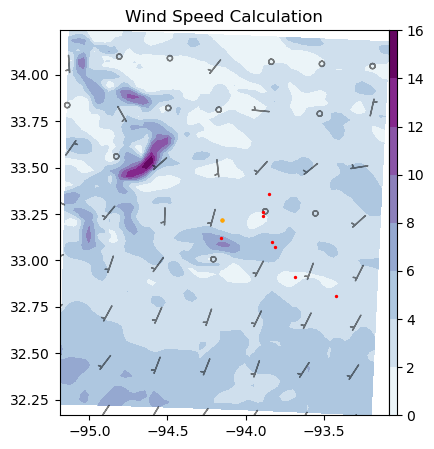

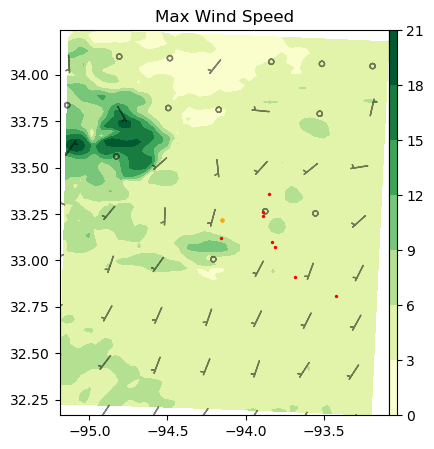

In [70]:
#1 Hour forecast
plot_interesting_events(tx_report, tx_filtered_reports, 1, 1)
# ds = fetch_rrfs_forecast(tx_report, 1)
# ds

3 Hour Forecast

2023-06-14 17:50:00 3


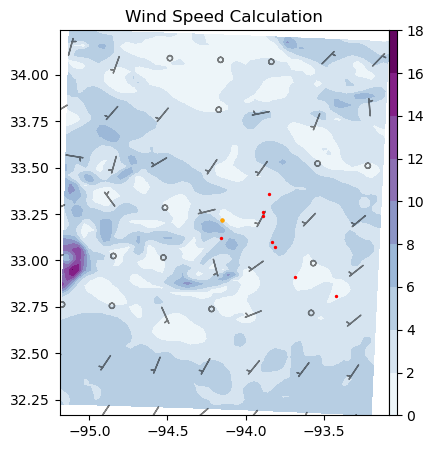

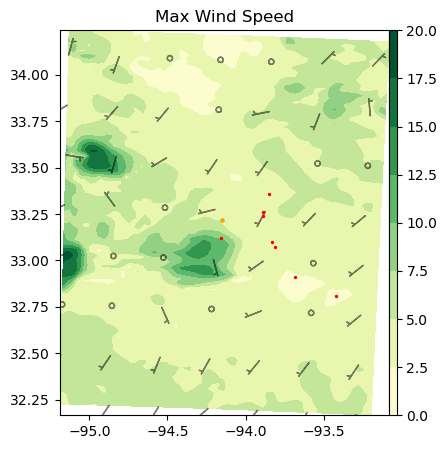

In [90]:
plot_interesting_events(tx_report, tx_filtered_reports, 3, 1)

6 Hours Forecast

2023-06-14 17:50:00 6
File succesfully downloaded


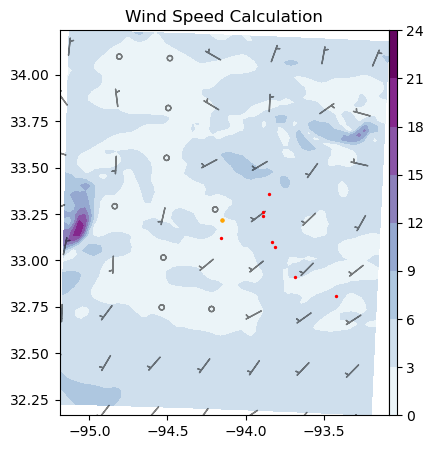

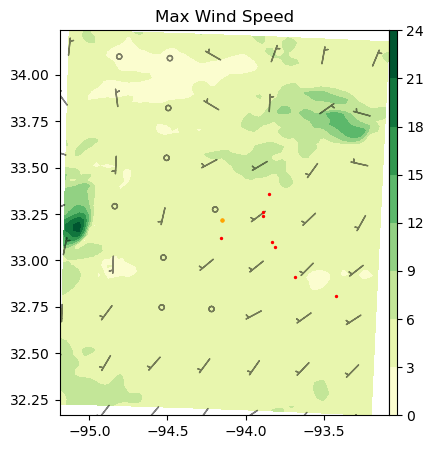

In [60]:
plot_interesting_events(tx_report, tx_filtered_reports, 6, 1)

9 Hour forecast

2023-06-14 17:50:00 9
File succesfully downloaded


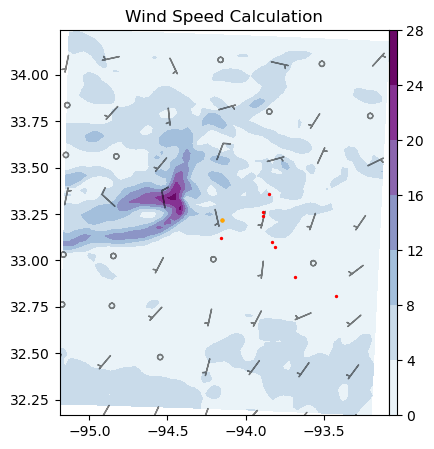

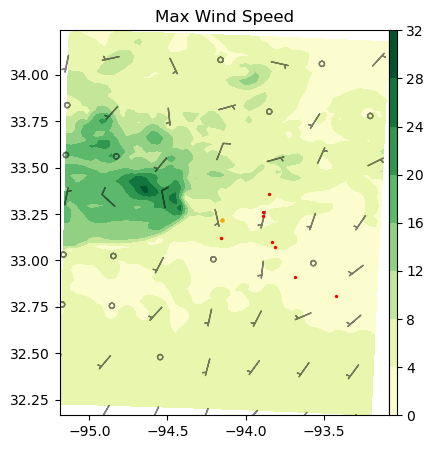

In [61]:
plot_interesting_events(tx_report, tx_filtered_reports, 9, 1)

## 1.3 GA Storm ##

In [45]:
ga_report = wind_reports.loc[26]
ga_report

Speed                                                  UNK
Location                                       3 SW Helena
County                                             Telfair
State                                                   GA
Lat                                                  32.04
Lon                                                 -82.96
Comments    Tree down at HWY 280 and Ken White Road. (FFC)
datetime                               2023-06-14 15:16:00
Name: 26, dtype: object

In [88]:
ga_filtered_events = filter_events(wind_reports, ga_report, 1, 1.5)
ga_filtered_events

,Speed,Location,County,State,Lat,Lon,Comments,datetime
26,UNK,3 SW Helena,Telfair,GA,32.04,-82.96,Tree down at HWY 280 and Ken White Road. (FFC),2023-06-14 15:16:00


2023-06-14 15:16:00 3


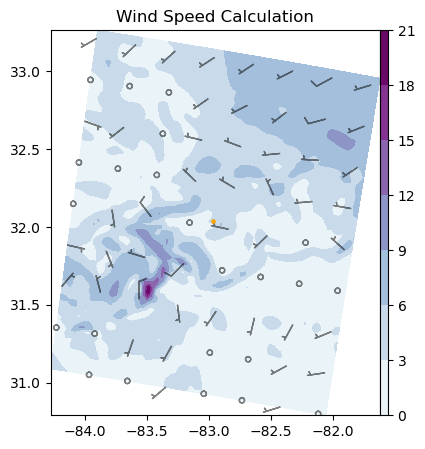

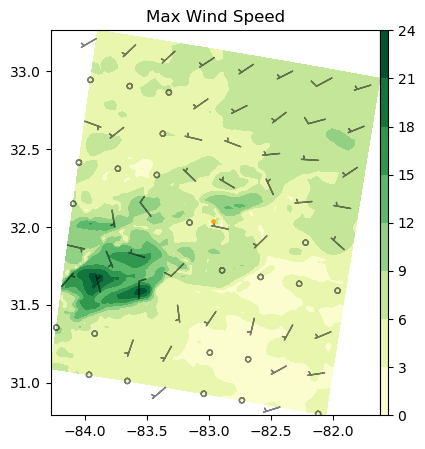

In [89]:
plot_interesting_events(ga_report, ga_filtered_events, 3, 1)

2023-06-14 15:16:00 6


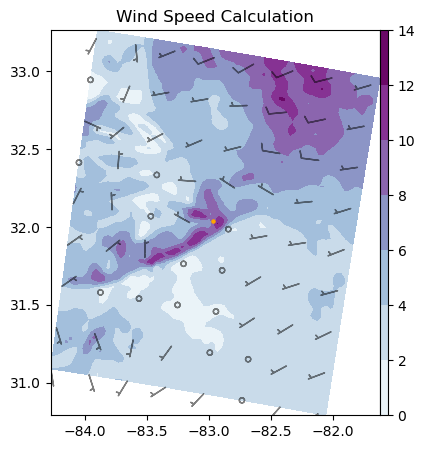

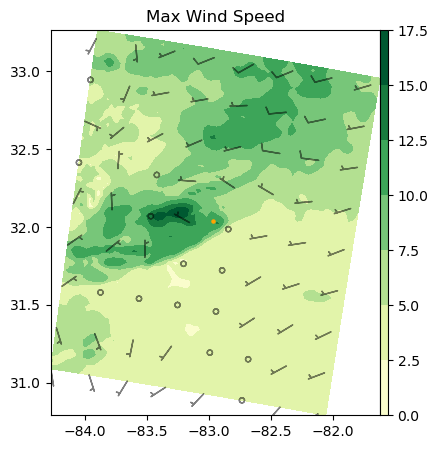

In [82]:
plot_interesting_events(ga_report, ga_filtered_events, 6, 1)

2023-06-14 15:16:00 9


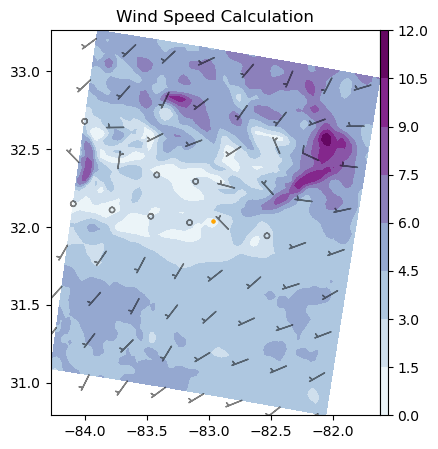

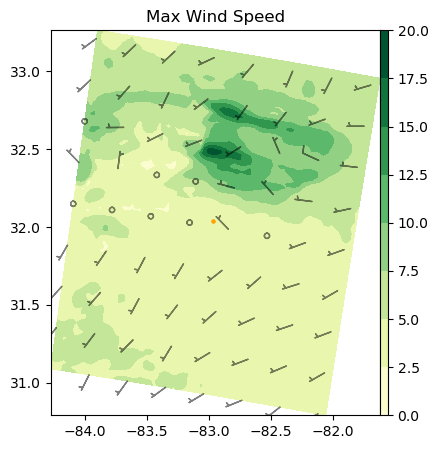

In [83]:
plot_interesting_events(ga_report, ga_filtered_events, 9, 1)

##  1.3 Alabama ##

In [44]:
al_report = wind_reports.loc[45]
al_report

Speed                                              UNK
Location                                    2 WSW Clay
County                                       Jefferson
State                                               AL
Lat                                              33.69
Lon                                             -86.63
Comments    Tree on a house on Dewey Heights Rd. (BMX)
datetime                           2023-06-14 18:45:00
Name: 45, dtype: object

In [75]:
al_filtered_events = filter_events(wind_reports, al_report, 1, 1.)
al_filtered_events

,Speed,Location,County,State,Lat,Lon,Comments,datetime
30,UNK,2 WNW Whitney Junction,St. Clair,AL,33.89,-86.33,Trees and power lines down on Crawford Cove Rd...,2023-06-14 17:45:00
33,UNK,3 NE Lynn,Winston,AL,34.08,-87.51,Tree down on CR 25. (BMX),2023-06-14 17:53:00
40,UNK,2 S Manchester,Walker,AL,33.87,-87.25,Trees down on Walston Bridge Rd. (BMX),2023-06-14 18:24:00
42,UNK,2 NNE Village Springs,Blount,AL,33.79,-86.63,Tree on vehicle on Red Valley Lane. (BMX),2023-06-14 18:28:00
43,UNK,2 N Smoke Rise,Blount,AL,33.91,-86.83,Trees down along HWY 31. (BMX),2023-06-14 18:29:00
44,UNK,2 NNE Smoke Rise,Blount,AL,33.90,-86.81,RV overturned on Hallmark Rd. (BMX),2023-06-14 18:30:00
45,UNK,1 ENE Smoke Rise,Blount,AL,33.89,-86.80,Trees and powerlines down on Rock Springs Rd. ...,2023-06-14 18:31:00
46,UNK,1 NE Warrior,Jefferson,AL,33.83,-86.79,Trees down on Warrior Trafford Rd. (BMX),2023-06-14 18:36:00
47,UNK,2 WSW Clay,Jefferson,AL,33.69,-86.63,Tree on a house on Dewey Heights Rd. (BMX),2023-06-14 18:45:00
49,UNK,1 ESE Argo,St. Clair,AL,33.69,-86.50,Tree blocking road on Briar Ridge Circle. (BMX),2023-06-14 18:58:00


2023-06-14 18:45:00 1


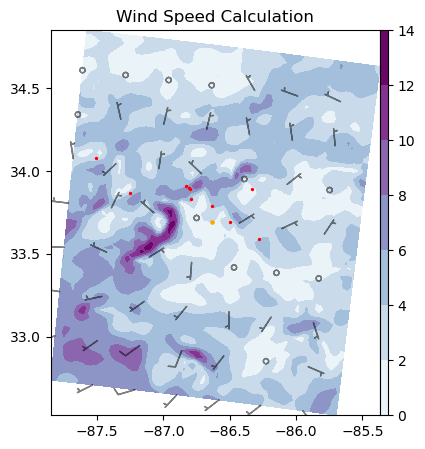

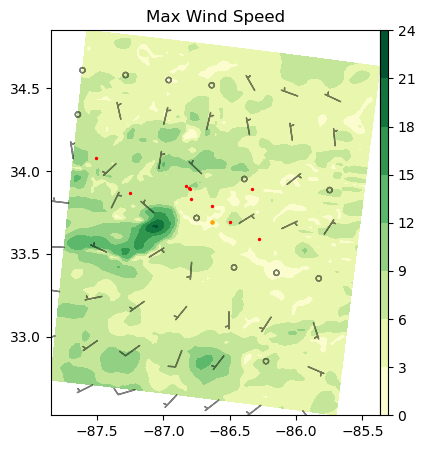

In [76]:
plot_interesting_events(al_report, al_filtered_events, 1, 1)

2023-06-14 18:45:00 3


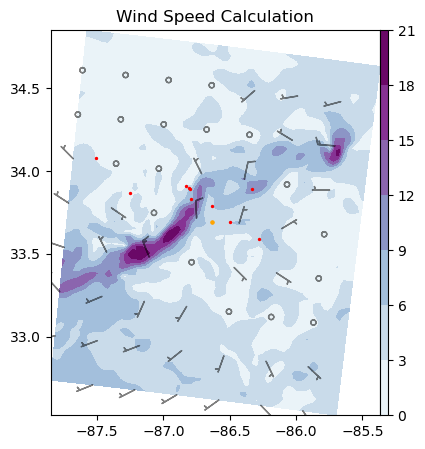

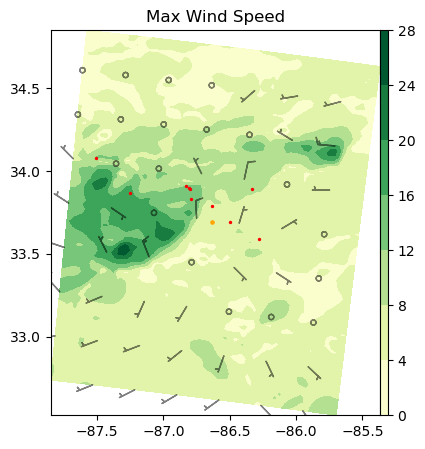

In [78]:
plot_interesting_events(al_report, al_filtered_events, 3, 1)

2023-06-14 18:45:00 6


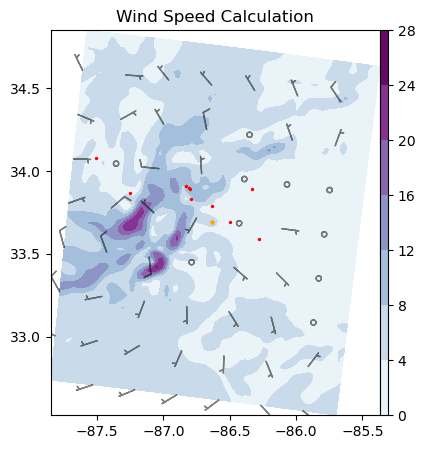

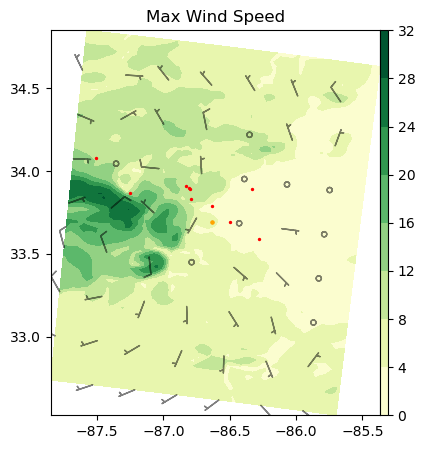

In [79]:
plot_interesting_events(al_report, al_filtered_events, 6, 1)

2023-06-14 18:45:00 9


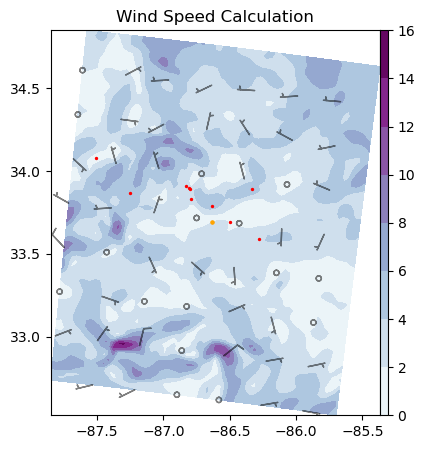

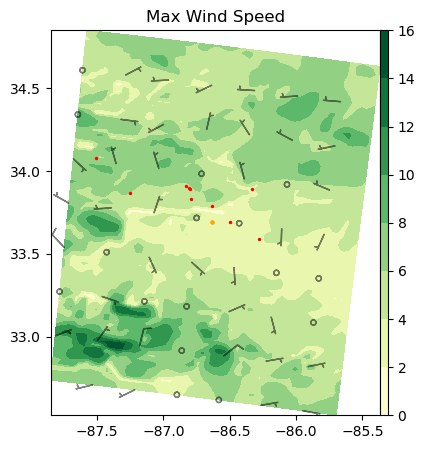

In [80]:
plot_interesting_events(al_report, al_filtered_events, 9, 1)

In [19]:
import matplotlib.pyplot as plt
import metpy.calc as mpcalc

def plot_max_wind_speed(ds, interesting_events, center_event, offset=3):

    # Calculate the total deformation of the flow
    wind_speed = mpcalc.wind_speed(ds.MAXUW_P8_L103_GLC0_max1h, ds.MAXVW_P8_L103_GLC0_max1h)
    # start figure and set axis
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # plot wind speed
    cf = ax.contourf(ds.coords['gridlon_0'], 
                     ds.coords['gridlat_0'], 
                     wind_speed, cmap=plt.cm.BuPu)
    plt.colorbar(cf, pad=0, aspect=50)
    ax.barbs(ds.coords['gridlon_0'][0::offset, 0::offset],
             ds.coords['gridlat_0'][0::offset, 0::offset],
             ds.UGRD_P0_L103_GLC0[0::offset, 0::offset], 
             ds.VGRD_P0_L103_GLC0[0::offset, 0::offset], 
             color='black', length=5, alpha=0.5)
   
    ax.set_title('Wind Speed Calculation')
    
    plt.scatter(
            x = interesting_events["Lon"],
            y = interesting_events["Lat"],
            color="red",
            s=2,
            alpha=1
        )
    
    plt.scatter(
        x=center_event["Lon"],
        y=center_event["Lat"],
        color="Orange",
        s=5
    )
    plt.show()



2023-06-14 18:15:00 3


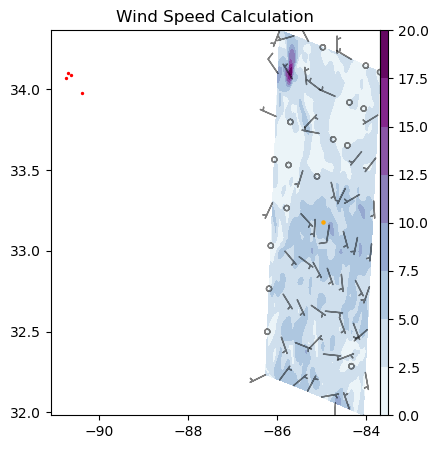

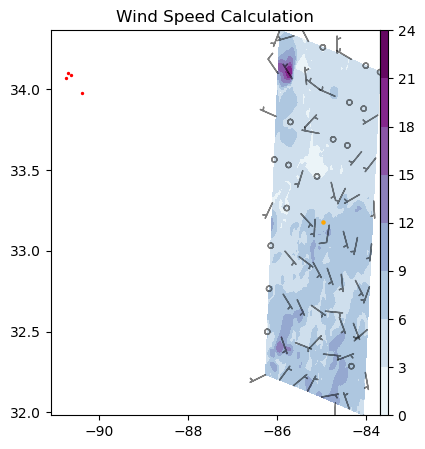

In [57]:
ga_report_2 = wind_reports.loc[34]
ga_filtered_events_2 = filter_events(wind_reports, ga_report, 1, 1.5)
plot_interesting_events(ga_report_2, ga_filtered_events_2, 3)

2023-06-14 14:26:00 6
File succesfully downloaded


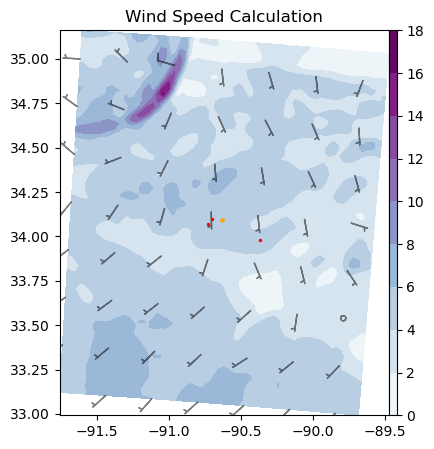

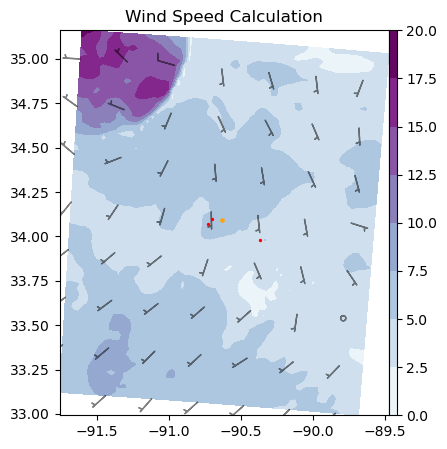

In [55]:
ga_report = wind_reports.loc[24]
ga_filtered_events = filter_events(wind_reports, ga_report)
plot_interesting_events(ga_report, ga_filtered_events, 6)

2023-06-14 14:26:00 9
File succesfully downloaded


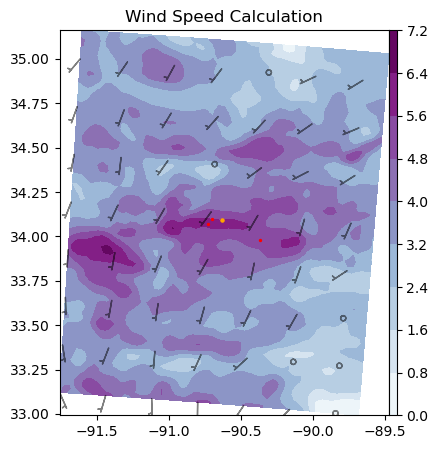

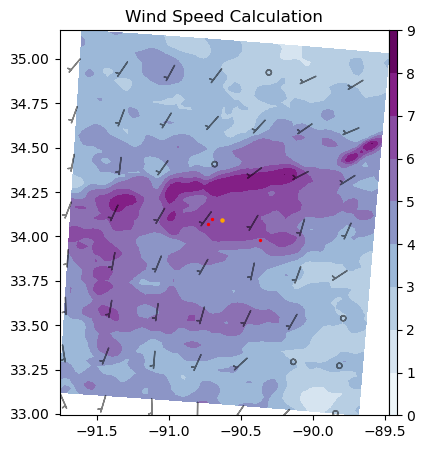

In [56]:
ga_report = wind_reports.loc[24]
ga_filtered_events = filter_events(wind_reports, ga_report)
plot_interesting_events(ga_report, ga_filtered_events, 9)